In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from edward.models import Normal, Dirichlet

In [2]:
from edward.models import RandomVariable
from tensorflow.python.framework import dtypes
from tensorflow.contrib.distributions import Distribution, NOT_REPARAMETERIZED

# Inputs are matrices, but value of random variable is a vector 
# whose length is the number of revealed entries (data_size).
# This is to accommodate a different number of cutpoints per question.
class distributions_OrdinalLogit(Distribution):
    def __init__(self, logits, cutpoints, indicators, name="OrdinalLogit"):
        self._logits = logits  # N x K tensor
        self._cutpoints = cutpoints  # K x max(N_CUT_VEC) tensor
        self._indicators = indicators  # N x K tensor
        
        parameters = dict(locals())
        super(distributions_OrdinalLogit, self).__init__(
            dtype=dtypes.int32,
            reparameterization_type=NOT_REPARAMETERIZED,
            validate_args=False,
            allow_nan_stats=True,
            parameters=parameters,
            graph_parents=[self._logits, self._cutpoints, self._indicators],
            name=name
        )

    def _cumul_probs(self):
        # form a N x K x max(N_CUT_VEC) tensor representing sum of logits and cutpoints
        # use broadcasting
        logits_with_cutpoints = tf.expand_dims(self._logits, -1) + tf.expand_dims(self._cutpoints, 0)
        # now subset to a data_size x max(N_CUT_VEC) array using indicators
        select_logits_with_cutpoints = tf.boolean_mask(logits_with_cutpoints, self._indicators)
        return tf.sigmoid(select_logits_with_cutpoints)  # data_size x max(N_CUT_VEC)
        
    def _log_prob(self, value):        
        cumul_probs = self._cumul_probs()
        data_size = tf.shape(cumul_probs)[0]
        level_probs = tf.concat([cumul_probs, tf.expand_dims(tf.ones([data_size]), -1)], axis=1) - \
                        tf.concat([tf.expand_dims(tf.zeros([data_size]), -1), cumul_probs], axis=1)
        levels = value
        indices_2d = tf.transpose(tf.stack([tf.range(data_size), levels]))  # n x 2
        selected_probs = tf.gather_nd(level_probs, indices_2d)
        
        return tf.reduce_sum(tf.log(selected_probs))
    
    def _sample_n(self, n, seed=None):
        cumul_probs = self._cumul_probs()
        data_size = tf.shape(cumul_probs)[0]
        new_shape = [n, data_size]
        sample_probs = tf.expand_dims(tf.random_uniform(new_shape), -1)
        booleans = tf.greater(sample_probs, cumul_probs)  # using broadcasting
        samples = tf.reduce_sum(tf.cast(booleans, dtype=dtypes.int32), axis=-1)
        return samples
    
    def mean(self):
        # Using the identity that the mean is \sum_{i=0}^k P(X > i)
        cumul_probs = self._cumul_probs()
        means = tf.reduce_sum(1-cumul_probs, axis=1)
        return means
        

def __init__(self, *args, **kwargs):
    RandomVariable.__init__(self, *args, **kwargs)

_name = 'OrdinalLogit'
_candidate = distributions_OrdinalLogit
__init__.__doc__ = _candidate.__init__.__doc__
_globals = globals()
_params = {'__doc__': _candidate.__doc__,
           '__init__': __init__,
           'support': 'countable'}
_globals[_name] = type(_name, (RandomVariable, _candidate), _params)

In [3]:
class FLAGS:
    N=50
    M=60
    D=3
    # length-M vector representing number of cutpoints per question
#     N_CUT_VEC = np.repeat(5, M)
    N_CUT_VEC = np.repeat(np.arange(3, 7)[:,np.newaxis], 15, axis=1).T.reshape(-1)

In [4]:
def build_toy_dataset(U, V, N, M, max_val_vec, noise_std=0.1):
    R = np.dot(np.transpose(U), V) + np.random.normal(0, noise_std, size=(N, M))
    # use numpy broadcasting rule 1 in 
    # https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html
    return np.round(np.clip(R, 0, max_val_vec)).astype(int)

def get_indicators(N, M, prob_std=0.5):
    ind = np.random.binomial(1, prob_std, (N, M))
    return ind

def logit(p):
    return tf.log(p / (1-p))

In [5]:
ed.set_seed(2018)

# true latent factors
U_true = np.random.randn(FLAGS.D, FLAGS.N)
V_true = np.random.randn(FLAGS.D, FLAGS.M)
# add some structure to latent factors
U_true[:,:FLAGS.N//2] += 0.5
U_true[:,FLAGS.N//2:] -= 0.5
V_true[:,:FLAGS.M//2] += 0.5
V_true[:,FLAGS.M//2:] -= 0.5

# DATA
R_true = build_toy_dataset(U_true, V_true, FLAGS.N, FLAGS.M, FLAGS.N_CUT_VEC)
I_train = get_indicators(FLAGS.N, FLAGS.M).astype(bool)
R_train = R_true[I_train]

# MODEL
I = tf.placeholder(tf.float32, [FLAGS.N, FLAGS.M])
U = Normal(loc=0.0, scale=1.0, sample_shape=[FLAGS.D, FLAGS.N])
V = Normal(loc=0.0, scale=1.0, sample_shape=[FLAGS.D, FLAGS.M])
# R = Normal(loc=tf.matmul(tf.transpose(U), V) * I,
#            scale=tf.ones([FLAGS.N, FLAGS.M]))
# R = Bernoulli(logits=tf.matmul(tf.transpose(U), V) * I)

logits = tf.matmul(tf.transpose(U), V)

# Using Dirichlet prior to define cutpoints, per rstanarm:
# https://cran.r-project.org/web/packages/rstanarm/vignettes/polr.html
all_ones = tf.ones(shape=(FLAGS.N_CUT_VEC.size, FLAGS.N_CUT_VEC.max()+1), dtype=dtypes.int64)
all_zeros = tf.zeros(shape=all_ones.shape, dtype=dtypes.int64)
range_per_row = tf.cumsum(all_ones, axis=1) - 1
keep_one_mask = tf.less_equal(range_per_row, tf.expand_dims(FLAGS.N_CUT_VEC, 1))
# inflate concentration parameters to get closer to uniform
# if we don't reduce noise this way, ELBO optimization may not converge
conc_multiple = 2
concentration = tf.cast(tf.where(keep_one_mask, all_ones * conc_multiple, all_zeros), dtypes.float32)
pi = Dirichlet(concentration)
cumpi = tf.cumsum(pi, axis=1)
cutpoints = logit(tf.minimum(cumpi, 1-1e-6))[:,:-1]
# exclude the final cumulative probability of 1, ensure numerical stability
# cutpoints has shape M x max(N_CUT_VEC)

# In order to represent cutpoints for all questions in a single 2d array,
# we are relying on cutpoint collapse
# np.round(cutpoints.eval(), 1)

R = OrdinalLogit(logits=logits, cutpoints=cutpoints, indicators=I)

# INFERENCE
qU = Normal(loc=tf.get_variable("qU/loc", [FLAGS.D, FLAGS.N]),
          scale=tf.nn.softplus(
              tf.get_variable("qU/scale", [FLAGS.D, FLAGS.N])))
qV = Normal(loc=tf.get_variable("qV/loc", [FLAGS.D, FLAGS.M]),
          scale=tf.nn.softplus(
              tf.get_variable("qV/scale", [FLAGS.D, FLAGS.M])))

# qpi = Dirichlet(tf.nn.softplus(
#     tf.Variable(tf.ones([FLAGS.N_CUT+1]), name="qpi/concentration")))
# inference = ed.KLqp({U: qU, V: qV, pi: qpi}, data={R: R_train, I: I_train})

# qa = Normal(loc = tf.get_variable("qa_loc", [1]),
#            scale = tf.nn.softplus(tf.get_variable("qa_scale", [1])))
# qb = Normal(loc = tf.get_variable("qb_loc", [1]),
#            scale = tf.nn.softplus(tf.get_variable("qb_scale", [1])))
# inference = ed.KLqp({U: qU, V: qV, a: qa, b: qb}, data={R: R_train, I: I_train})

inference = ed.KLqp({U: qU, V: qV}, data={R: R_train, I: I_train})
inference.run()

# CRITICISM
# qR = OrdinalLogit(
#     logits=tf.boolean_mask(Normal(loc=tf.matmul(tf.transpose(qU), qV), scale=tf.ones([FLAGS.N, FLAGS.M])), I),
#     cutpoints=cutpoints
# )
qR = OrdinalLogit(
    logits=tf.matmul(tf.transpose(qU), qV),
    cutpoints=cutpoints,
    indicators=I
)

R_test = R_true[~I_train]
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={qR: R_test, I: ~I_train}))

/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


  10/1000 [  1%]                                ETA: 48s | Loss: 2906.588 

/Users/cyz/edward/edward/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 1814.321
Mean squared error on test data:
0.550262


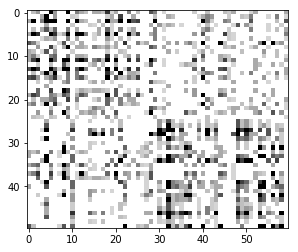

In [6]:
plt.imshow(R_true / FLAGS.N_CUT_VEC, cmap='binary')
plt.show()

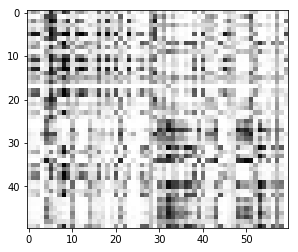

In [7]:
# evaluate at posterior mean
R_est = OrdinalLogit(
            logits=tf.matmul(tf.transpose(qU), qV),
            cutpoints=cutpoints,
            indicators=tf.ones(R_true.shape)
        ).mean().eval().reshape(R_true.shape)
plt.imshow(R_est / FLAGS.N_CUT_VEC, cmap='binary')
plt.show()

In [8]:
# Next: do inference on cutpoints since these will be used in item selection
# Actually, posterior inference on cutpoints with VI results in infinite loss.
# Currently using a single sample from Dirichlet prior,
# since according to http://edwardlib.org/api/inference,
# Latent variables can be defined in the model without any posterior inference over them. They are implicitly marginalized out with a single sample.
# The sample seems to work better than the mean...
